In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(reshape2)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)

filtered <- read.table("../7614_final_summary_anno3.txt",header=T,sep="\t")

names(filtered)

unique(filtered$Hemisphere)
unique(filtered$Region)
unique(filtered$Punch)
unique(filtered$Cell_Type)
unique(filtered$Location)
unique(filtered$AntPost)
unique(filtered$DorVen)
unique(filtered$Organ)
unique(filtered$Note)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




[1] "ID"                        "CHROM"                    
 [3] "POS"                       "REF"                      
 [5] "ALT"                       "CHROM.POS.REF.ALT"        
 [7] "ANNO"                      "GENE"                     
 [9] "GNOMAD_FREQ"               "REPEAT_MASKER"            
[11] "SEGDUP"                    "HOMOPOLYMER"              
[13] "REF_SEQ"                   "DINUCLEOTIDE"             
[15] "NEAR_INDEL"                "UCSC_RPMSK"               
[17] "REF_COUNT"                 "ALT_COUNT"                
[19] "MAF"                       "LOWER_CI"                 
[21] "UPPER_CI"                  "CI_IS_GREATER"            
[23] "NORMAL_REF_COUNT"          "NORMAL_ALT_COUNT"         
[25] "NORMAL_MAF"                "NORMAL_LOWER_CI"          
[27] "NORMAL_UPPER_CI"           "NORMAL_CI_IS_GREATER"     
[29] "Mosaic"                    "Mosaic_shared_btw_WGS_Amp"
[31] "Hemisphere"                "Region"                   
[33] "Punch"                     "Cell_Type"                
[35] "Location"                  "AntPost"                  
[37] "DorVen"                    "Organ"                    
[39] "Note"                      "Bulk_main"                
[41] "Sort_main"                 "CTX_BG_HIP_relationship"  
[43] "Organ_main"

[1] "L" NA  "R"

[1] "T"    "Cb"   NA     "Cau"  "Amg"  "GP"   "Put"  "Hip"  "Thal" "CA1" 
[11] "CA3"  "DG"   "Sub"  "Ins"  "F"    "O"    "P"    "PF"   "Clo"

[1]  NA 141   2   3   1   4   5   6  10   7   8   9 144 145  34  35  36  37  72
[20]  73  74  75  29  57  43  15  99 127 113  85  71

[1] "Bulk"           "Cardiomyocyte"  "COUPTF2"        "DLX1"          
 [5] "DARPP32M-NeuNP" "DARPP32P-NeuNP" "TBR1"           "NeuN"          
 [9] "LHX2"           "Olig2"          "PU1"

[1] NA  "C" "P" "V" "A" "D"

[1] "Post" NA     "Ant"

[1] "Ven" NA    "Dor"

[1] "CTX"    "CB"     "Heart"  "Kidney" "BG"     "AMG"    "HIP"    "THAL"  
 [9] "SUB"    "Liver"  "CLO"    "JGG"

[1] "LARGE" "SMALL" NA

In [2]:
print(paste("A total of variant calls: ",nrow(filtered)))
print(paste("The number of variants included in ampliseq: ", length(unique(filtered$CHROM.POS.REF.ALT))))

filtered2 <- subset(filtered, Organ_main %in% c('1'))
filtered2$Punch<-as.character(filtered2$Punch)
filtered2$Note<-as.character(filtered2$Note)

mosaic_filtered <- filtered2[filtered2$Mosaic_shared_btw_WGS_Amp==1,]
mosaic_filtered_cutoff <- subset(mosaic_filtered, LOWER_CI>0.001677998 & UPPER_CI<0.3923302 & NORMAL_LOWER_CI<0.001677998)

print(paste("The number of validated MVs: ", length(unique(mosaic_filtered$CHROM.POS.REF.ALT))))
print(paste("The number of validated MV calls: ", length(mosaic_filtered_cutoff$CHROM.POS.REF.ALT)))

# statistics

variant_list<-unique(mosaic_filtered$CHROM.POS.REF.ALT)
variant_list<-as.data.frame(variant_list, row.names = variant_list) # assign rownames as CHROM.POS.REF.ALT
print(paste("The number of validated MVs (in the variant_list variable): ", nrow(variant_list)))
for (i in 1:nrow(variant_list)){
    xx <- filtered2[filtered2$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
    xx <- subset(xx, LOWER_CI>0.001677998 & UPPER_CI<0.3923302 & NORMAL_LOWER_CI<0.001677998 )
    n_row <- nrow(xx)
    variant_list$sample_number_presented[i] <- n_row
    }
print(paste("The number of validated MVs and detected in this 2023 Ampliseq: ", nrow(variant_list[variant_list$sample_number_presented>0,])))
# Non-private Mosaic variants
print(paste("The number of shared validated MVs : ",nrow(variant_list[variant_list$sample_number_presented>1,])))

[1] "A total of variant calls:  335124"
[1] "The number of variants included in ampliseq:  1044"
[1] "The number of validated MVs:  287"
[1] "The number of validated MV calls:  414"
[1] "The number of validated MVs (in the variant_list variable):  287"
[1] "The number of validated MVs and detected in this 2023 Ampliseq:  129"
[1] "The number of shared validated MVs :  79"


In [3]:
for (j in c('CTX','CB','Heart','Kidney','BG','THAL','Liver')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Organ)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('L','R')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Hemisphere)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('PF','F','P','O','T','Ins')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Region)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('Cau','Put','GP')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Region)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('Bulk','DLX1','TBR1','COUPTF2','Bulk','NeuN','LHX2','Olig2','PU1','DARPP32M-NeuNP','DARPP32P-NeuNP','Cardiomyocyte')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Cell_Type)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

In [21]:

Brain_only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0) & (CTX==1 | CB==1 | BG==1 |  THAL==1))
variant_list$Brain_only[variant_list$variant_list %in% rownames(Brain_only_variants)]<-1
variant_list$Brain_only[!variant_list$variant_list %in% rownames(Brain_only_variants)]<-0

CTX_only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & BG==0 & THAL==0) & (CTX==1))
variant_list$CTX_only[variant_list$variant_list %in% rownames(CTX_only_variants)]<-1
variant_list$CTX_only[!variant_list$variant_list %in% rownames(CTX_only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & THAL==0) & (CTX==1 | BG==1))
variant_list$CTX_BG_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$CTX_BG_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & THAL==0) & (CTX==1 & BG==1))
variant_list$CTX_BG_shared[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$CTX_BG_shared[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & BG==0) & (CTX==1 & THAL==1))
variant_list$CTX_THAL_shared[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$CTX_THAL_shared[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & THAL==0 & CTX==0) & (BG==1))
variant_list$BG_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$BG_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & BG==0 & CTX==0) & (THAL==1))
variant_list$THAL_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$THAL_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

#--------------------------------hemisphere only----------------------------------------
only_variants<-subset(variant_list, (L==1) & (R==0) & (Brain_only==1))
variant_list$Left_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$Left_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (R==1) & (L==0) & (Brain_only==1))
variant_list$Right_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$Right_only[!variant_list$variant_list %in% rownames(only_variants)]<-0



In [22]:
print(paste("PF present variants: ",nrow(variant_list[variant_list$PF==1,])))
print(paste("F present variants: ",nrow(variant_list[variant_list$F==1,])))
print(paste("P present variants: ",nrow(variant_list[variant_list$P==1,])))
print(paste("O present variants: ",nrow(variant_list[variant_list$O==1,])))
print(paste("Ins present variants: ",nrow(variant_list[variant_list$Ins==1,])))
print(paste("T present variants: ",nrow(variant_list[variant_list$T==1,])))
print(paste("Brain only variants: ",nrow(variant_list[variant_list$Brain_only==1,])))
print(paste("CTX_BG only variants: ",nrow(variant_list[variant_list$CTX_BG_only==1,])))
print(paste("CTX only variants: ",nrow(variant_list[variant_list$CTX_only==1,])))
print(paste("BG only variants: ",nrow(variant_list[variant_list$BG_only==1,])))
print(paste("THAL only variants: ",nrow(variant_list[variant_list$THAL_only==1,])))
print(paste("Left only variants: ",nrow(variant_list[variant_list$Left_only==1,])))
print(paste("Right only variants: ",nrow(variant_list[variant_list$Right_only==1,])))
print(paste("IN only variants: ",nrow(variant_list[variant_list$IN_only==1,])))
print(paste("COUP only variants: ",nrow(variant_list[variant_list$COUP_only==1,])))
print(paste("TBR only variants: ",nrow(variant_list[variant_list$TBR_only==1,])))
print(paste("TBR BR variants: ",nrow(variant_list[variant_list$TBR_BR==1,])))
print(paste("DLX BR variants: ",nrow(variant_list[variant_list$DLX_BR==1,])))
print(paste("COUPTF2_enriched variants: ",nrow(variant_list[variant_list$COUPTF2_enriched==1,])))

[1] "PF present variants:  118"
[1] "F present variants:  113"
[1] "P present variants:  116"
[1] "O present variants:  111"
[1] "Ins present variants:  100"
[1] "T present variants:  164"
[1] "Brain only variants:  138"
[1] "CTX_BG only variants:  110"
[1] "CTX only variants:  92"
[1] "BG only variants:  3"
[1] "THAL only variants:  0"
[1] "Left only variants:  62"
[1] "Right only variants:  57"
[1] "IN only variants:  0"
[1] "COUP only variants:  0"
[1] "TBR only variants:  0"
[1] "TBR BR variants:  0"
[1] "DLX BR variants:  0"
[1] "COUPTF2_enriched variants:  0"


In [23]:
variant_list2 <- variant_list[,-1]
colnames(variant_list2)<- paste0(colnames(variant_list2), "_Bulk")

In [24]:
write.csv(variant_list,"./287_variant_annotation_bulk.csv")

In [25]:
data<-as.data.frame(colSums(variant_list[,-1:-15]))
colnames(data)<-(c('count'))
total<-287
data<-rbind(data,total)
row.names(data)[row.names(data) == "46"] <- "Total"
data<-subset(data,!rownames(data) %in% c("Bulk","Cardiomyocyte"))

In [26]:
data

,count
,<dbl>
T,164
Ins,100
Cau,0
Put,97
GP,89
DLX1,0
TBR1,0
COUPTF2,0
NeuN,0


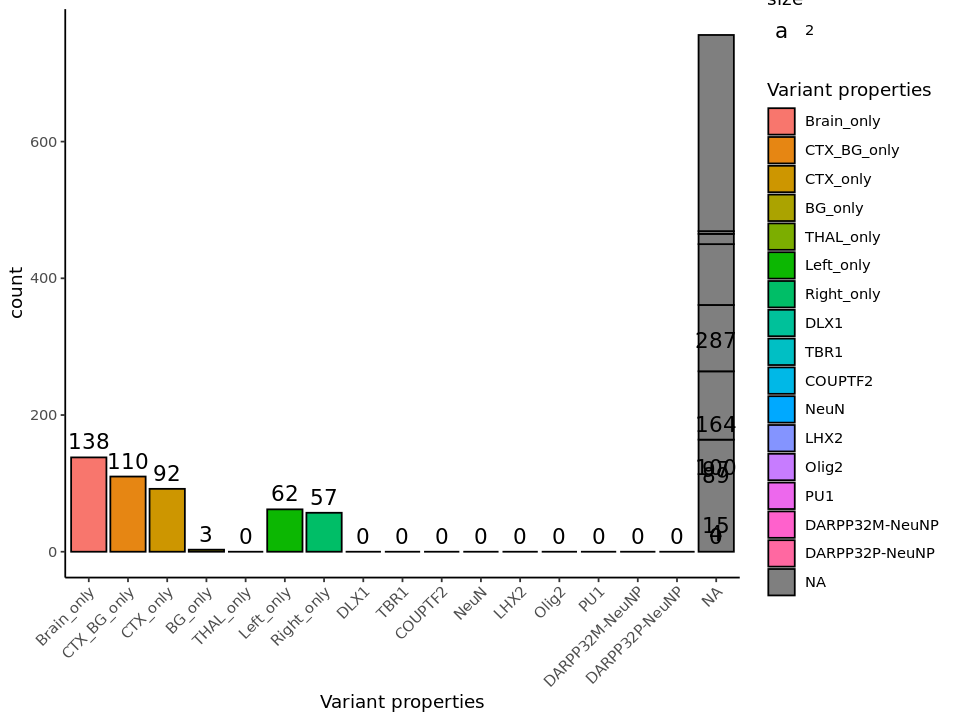

In [27]:
xxx<-factor(rownames(data), level=c("Total","Brain_only","CTX_BG_only","CTX_only","BG_only",
                                    "THAL_only","Left_only","Right_only","DLX1","TBR1","COUPTF2","NeuN","LHX2","Olig2","PU1","DARPP32M-NeuNP",
                                    "DARPP32P-NeuNP","IN_only","COUP_only","TBR_only","TBR_BR","DLX_BR",'MSN_BR','nonMSN_BR' ,
                                    'L_BR_PF_only','L_BR_F_only','L_BR_P_only','L_BR_O_only','L_BR_Ins_only',
                                    'R_BR_PF_only','R_BR_F_only','R_BR_P_only','R_BR_O_only','R_BR_Ins_only'))

options(repr.plot.width=8,repr.plot.height=6)
ggplot(data=data, aes(x=xxx, y=count, fill=xxx)) +
geom_bar(colour="black",stat='identity')+theme_classic() + labs(x='Variant properties', colour = "Variant properties", fill="Variant properties")+
geom_text(aes(label=data$count, vjust = -0.5, size=2)) + theme(axis.text.x=element_text(angle=45, hjust=1))

# Variant annotation without excluding any samples

In [2]:

print(paste("A total of variant calls: ",nrow(filtered)))
print(paste("The number of variants included in ampliseq: ", length(unique(filtered$CHROM.POS.REF.ALT))))

filtered2 <- filtered
filtered2$Punch<-as.character(filtered2$Punch)
filtered2$Note<-as.character(filtered2$Note)

mosaic_filtered <- filtered2[filtered2$Mosaic_shared_btw_WGS_Amp==1,]
mosaic_filtered_cutoff <- subset(mosaic_filtered, LOWER_CI>0.001677998 & UPPER_CI<0.3923302 & NORMAL_LOWER_CI<0.001677998)

print(paste("The number of validated MVs: ", length(unique(mosaic_filtered$CHROM.POS.REF.ALT))))
print(paste("The number of validated MV calls: ", length(mosaic_filtered_cutoff$CHROM.POS.REF.ALT)))

# statistics

variant_list<-unique(mosaic_filtered$CHROM.POS.REF.ALT)
variant_list<-as.data.frame(variant_list, row.names = variant_list) # assign rownames as CHROM.POS.REF.ALT
print(paste("The number of validated MVs (in the variant_list variable): ", nrow(variant_list)))
for (i in 1:nrow(variant_list)){
    xx <- filtered2[filtered2$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
    xx <- subset(xx, LOWER_CI>0.001677998 & UPPER_CI<0.3923302 & NORMAL_LOWER_CI<0.001677998 )
    n_row <- nrow(xx)
    variant_list$sample_number_presented[i] <- n_row
    }
print(paste("The number of validated MVs and detected in this 2023 Ampliseq: ", nrow(variant_list[variant_list$sample_number_presented>0,])))
# Non-private Mosaic variants
print(paste("The number of shared validated MVs : ",nrow(variant_list[variant_list$sample_number_presented>1,])))

[1] "A total of variant calls:  335124"
[1] "The number of variants included in ampliseq:  1044"
[1] "The number of validated MVs:  287"
[1] "The number of validated MV calls:  16771"
[1] "The number of validated MVs (in the variant_list variable):  287"
[1] "The number of validated MVs and detected in this 2023 Ampliseq:  253"
[1] "The number of shared validated MVs :  199"


In [3]:
for (j in c('CTX','CB','Heart','Kidney','BG','AMG','HIP','THAL','SUB','Liver','CLO')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Organ)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('L','R')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Hemisphere)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('PF','F','P','O','T','Ins')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Region)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('Cau','Put','GP')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Region)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

for (j in c('Bulk','DLX1','TBR1','COUPTF2','Bulk','NeuN','LHX2','Olig2','PU1','DARPP32M-NeuNP','DARPP32P-NeuNP','Cardiomyocyte')){
    for (i in 1:nrow(variant_list)){
        xx <- mosaic_filtered_cutoff[mosaic_filtered_cutoff$CHROM.POS.REF.ALT == variant_list$variant_list[i],]
        if(j %in% unique(xx$Cell_Type)){variant_list[i,j] <- 1}
        else{variant_list[i,j] <- 0}
        }
}

In [4]:

Brain_only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0) & (CTX==1 | CB==1 | BG==1 | THAL==1 | AMG==1 | HIP==1 | SUB==1 | CLO==1))
variant_list$Brain_only[variant_list$variant_list %in% rownames(Brain_only_variants)]<-1
variant_list$Brain_only[!variant_list$variant_list %in% rownames(Brain_only_variants)]<-0

CTX_only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & BG==0 & THAL==0 & AMG==0 & HIP==0 & SUB==0 & CLO==0) & (CTX==1))
variant_list$CTX_only[variant_list$variant_list %in% rownames(CTX_only_variants)]<-1
variant_list$CTX_only[!variant_list$variant_list %in% rownames(CTX_only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & THAL==0 & CTX==0 & AMG==0 & HIP==0 & SUB==0 & CLO==0) & (BG==1))
variant_list$BG_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$BG_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & THAL==0 & CTX==0 & AMG==0 & BG==0 & SUB==0 & CLO==0) & (HIP==1))
variant_list$HIP_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$HIP_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & BG==0 & CTX==0 & AMG==0 & HIP==0 & SUB==0 & CLO==0) & (THAL==1))
variant_list$THAL_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$THAL_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Liver==0 & Heart==0 & Kidney==0 & CB==0 & THAL==0 & AMG==0 & HIP==0 & SUB==0 & CLO==0) & (CTX==1 | BG==1))
variant_list$CTX_BG_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$CTX_BG_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Brain_only==1) & (CTX==1 & BG==1))
variant_list$CTX_BG_shared[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$CTX_BG_shared[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Brain_only==1) & (CTX==1 & HIP==1))
variant_list$CTX_HIP_shared[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$CTX_HIP_shared[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Brain_only==1) & (BG==1 & HIP==1))
variant_list$HIP_BG_shared[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$HIP_BG_shared[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (Brain_only==1) & (CTX==1 & THAL==1))
variant_list$CTX_THAL_shared[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$CTX_THAL_shared[!variant_list$variant_list %in% rownames(only_variants)]<-0



#--------------------------------hemisphere only----------------------------------------
only_variants<-subset(variant_list, (L==1) & (R==0) & (Brain_only==1))
variant_list$Left_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$Left_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (R==1) & (L==0) & (Brain_only==1))
variant_list$Right_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$Right_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

#---------------------------------cell type only-----------------------------------------
only_variants<-subset(variant_list, (TBR1==0) & (DLX1==1 | COUPTF2==1) & (Brain_only==1))
variant_list$IN_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$IN_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (TBR1==0) & (COUPTF2==1) & (Brain_only==1))
variant_list$COUP_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$COUP_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (DLX1==0 & COUPTF2==0) & (TBR1==1) & (Brain_only==1))
variant_list$TBR_only[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$TBR_only[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (TBR1==1) & (Brain_only==1))
variant_list$TBR_BR[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$TBR_BR[!variant_list$variant_list %in% rownames(only_variants)]<-0

only_variants<-subset(variant_list, (DLX1==1) & (Brain_only==1))
variant_list$DLX_BR[variant_list$variant_list %in% rownames(only_variants)]<-1
variant_list$DLX_BR[!variant_list$variant_list %in% rownames(only_variants)]<-0

In [5]:
print(paste("Brain only variants: ",nrow(variant_list[variant_list$Brain_only==1,])))
print(paste("CTX only variants: ",nrow(variant_list[variant_list$CTX_only==1,])))
print(paste("BG only variants: ",nrow(variant_list[variant_list$BG_only==1,])))
print(paste("HIP only variants: ",nrow(variant_list[variant_list$HIP_only==1,])))
print(paste("THAL only variants: ",nrow(variant_list[variant_list$THAL_only==1,])))
print(paste("CTX and BG shared variants: ",nrow(variant_list[variant_list$CTX_BG_shared==1,])))
print(paste("CTX and HIP shared variants: ",nrow(variant_list[variant_list$CTX_HIP_shared==1,])))
print(paste("HIP and BG shared variants: ",nrow(variant_list[variant_list$HIP_BG_shared==1,])))
print(paste("CTX and THAL shared variants: ",nrow(variant_list[variant_list$CTX_THAL_shared==1,])))
print(paste("Left only variants: ",nrow(variant_list[variant_list$Left_only==1,])))
print(paste("Right only variants: ",nrow(variant_list[variant_list$Right_only==1,])))
print(paste("IN only variants: ",nrow(variant_list[variant_list$IN_only==1,])))
print(paste("COUP only variants: ",nrow(variant_list[variant_list$COUP_only==1,])))
print(paste("TBR only variants: ",nrow(variant_list[variant_list$TBR_only==1,])))
print(paste("TBR BR variants: ",nrow(variant_list[variant_list$TBR_BR==1,])))
print(paste("DLX BR variants: ",nrow(variant_list[variant_list$DLX_BR==1,])))

[1] "Brain only variants:  87"
[1] "CTX only variants:  53"
[1] "BG only variants:  3"
[1] "HIP only variants:  0"
[1] "THAL only variants:  1"
[1] "CTX and BG shared variants:  147"
[1] "CTX and HIP shared variants:  6"
[1] "HIP and BG shared variants:  5"
[1] "CTX and THAL shared variants:  13"
[1] "Left only variants:  42"
[1] "Right only variants:  30"
[1] "IN only variants:  8"
[1] "COUP only variants:  6"
[1] "TBR only variants:  2"
[1] "TBR BR variants:  26"
[1] "DLX BR variants:  25"


In [6]:
write.csv(variant_list,"./287_variant_annotation_by_all_samples.csv")

In [7]:
variant_list <- read.table("./287_variant_annotation_by_all_samples.csv",header=T,sep=",",row.names=1)

In [8]:
names(variant_list)

[1] "variant_list"            "sample_number_presented"
 [3] "CTX"                     "CB"                     
 [5] "Heart"                   "Kidney"                 
 [7] "BG"                      "AMG"                    
 [9] "HIP"                     "THAL"                   
[11] "SUB"                     "Liver"                  
[13] "CLO"                     "L"                      
[15] "R"                       "PF"                     
[17] "F"                       "P"                      
[19] "O"                       "T"                      
[21] "Ins"                     "Cau"                    
[23] "Put"                     "GP"                     
[25] "Bulk"                    "DLX1"                   
[27] "TBR1"                    "COUPTF2"                
[29] "NeuN"                    "LHX2"                   
[31] "Olig2"                   "PU1"                    
[33] "DARPP32M.NeuNP"          "DARPP32P.NeuNP"         
[35] "Cardiomyocyte"           "Brain_only"             
[37] "CTX_only"                "BG_only"                
[39] "HIP_only"                "THAL_only"              
[41] "CTX_BG_only"             "CTX_BG_shared"          
[43] "CTX_HIP_shared"          "HIP_BG_shared"          
[45] "CTX_THAL_shared"         "Left_only"              
[47] "Right_only"              "IN_only"                
[49] "COUP_only"               "TBR_only"               
[51] "TBR_BR"                  "DLX_BR"

In [9]:
data<-as.data.frame(colSums(variant_list[,-1:-2]))
colnames(data)<-(c('count'))
data<-data[c('Brain_only', 'CTX_only', 'BG_only', 'HIP_only', 'THAL_only',
             'CTX_BG_shared', 'CTX_HIP_shared', 'HIP_BG_shared', 'CTX_THAL_shared',
             'Left_only', 'Right_only', 'IN_only', 'COUP_only', 'TBR_only'),]
total<-287
data<-c(total,data)
# row.names(data)[row.names(data) == "35"] <- "Total"
# data<-subset(data,!rownames(data) %in% c("Bulk"))
names(data)<-c('Total','Brain_only', 'CTX_only', 'BG_only', 'HIP_only', 'THAL_only',
             'CTX_BG_shared', 'CTX_HIP_shared', 'HIP_BG_shared', 'CTX_THAL_shared',
             'Left_only', 'Right_only', 'IN_only', 'COUP_only', 'TBR_only')
data<-as.data.frame(data)
colnames(data)<-"Counts"

In [10]:
data

,Counts
,<dbl>
Total,287
Brain_only,87
CTX_only,53
BG_only,3
HIP_only,0
THAL_only,1
CTX_BG_shared,21
CTX_HIP_shared,6
HIP_BG_shared,5


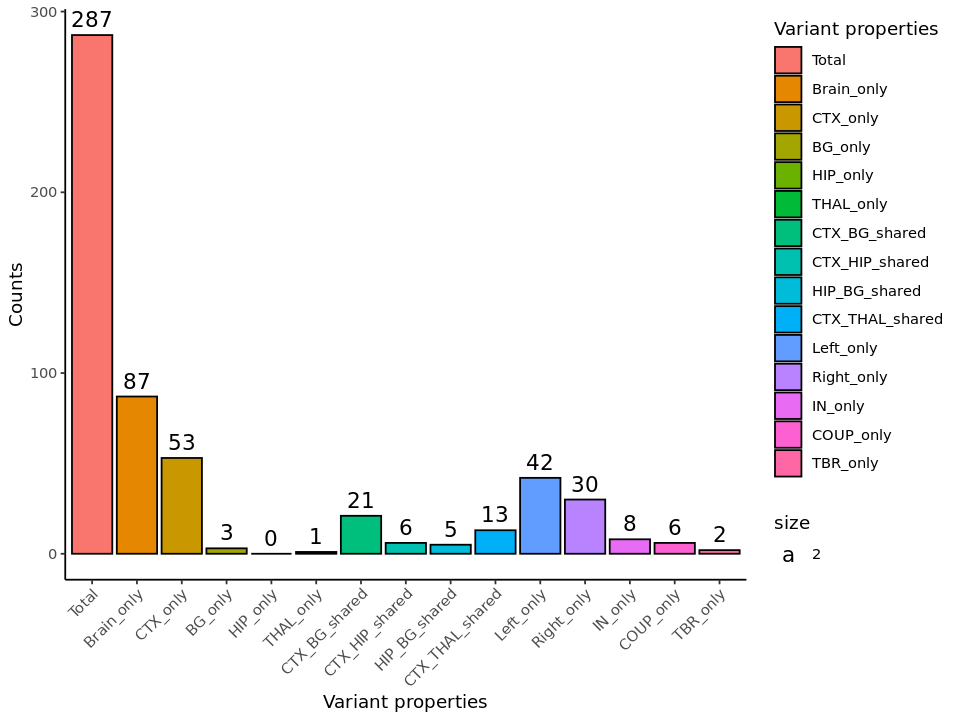

In [11]:
xxx<-factor(rownames(data), level=c('Total','Brain_only', 'CTX_only', 'BG_only', 'HIP_only', 'THAL_only',
             'CTX_BG_shared', 'CTX_HIP_shared', 'HIP_BG_shared', 'CTX_THAL_shared',
             'Left_only', 'Right_only', 'IN_only', 'COUP_only', 'TBR_only'))

options(repr.plot.width=8,repr.plot.height=6)
p<-ggplot(data=data, aes(x=xxx, y=Counts, fill=xxx)) +
geom_bar(colour="black",stat='identity')+theme_classic() + labs(x='Variant properties', colour = "Variant properties", fill="Variant properties")+
geom_text(aes(label=data$Counts, vjust = -0.5, size=2)) + theme(axis.text.x=element_text(angle=45, hjust=1))
p

In [41]:
pdf(file="./7614_VarByVar_287_All_Var.pdf",width=8,height=8)
p
dev.off()

png 
  2